## Preprocesamiento de datos


In [118]:
import pandas as pd

# Carga el Dataset
train_data = pd.read_excel("data/train.xlsx")

# Imprime el DataFrame
print(train_data.shape)
train_data.head()

# Agrega una nueva columna 'label' modificando los strings de la columna 'Category' a valores numéricos.
train_data['label'] = train_data['Category'].map({'Fake': 0, 'True': 1})

# Imprime el DataFrame
train_data.head()

(676, 7)


,Id,Category,Topic,Source,Headline,Text,Link,label
0,1,Fake,Education,El Ruinaversal,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",http://www.elruinaversal.com/2017/06/10/rae-in...,0
1,2,Fake,Education,Hay noticia,"La palabra ""haiga"", aceptada por la RAE","La palabra ""haiga"", aceptada por la RAE La Rea...",https://haynoticia.es/la-palabra-haiga-aceptad...,0
2,3,Fake,Education,El Ruinaversal,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,http://www.elruinaversal.com/2018/05/06/yordi-...,0
3,4,True,Education,EL UNIVERSAL,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...,1
4,5,Fake,Education,Lamula,pretenden aprobar libros escolares con conteni...,Alerta: pretenden aprobar libros escolares con...,https://redaccion.lamula.pe/2018/06/19/memoria...,0


Verificamos que nuestro dataset sea balanceado, es decir, que la cantidad de ejemplos de cada clase sea similar.

([<matplotlib.patches.Wedge at 0x1abd66d9f40>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'True')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

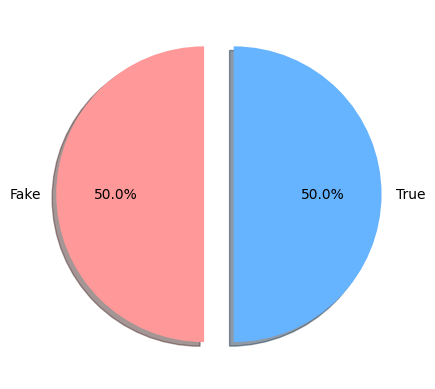

In [104]:
import matplotlib.pyplot as plt

label_size = [train_data['label'].sum(), len(train_data['label'])-train_data['label'].sum()]
plt.pie(label_size, explode=[0.1, 0.1], colors=['#ff9999','#66b3ff'], startangle=90, labels=['Fake', 'True'], autopct='%1.1f%%', shadow=True)

### Separación de datos en entrenamiento y test

In [119]:
# Se dividirá en un 70% para entrenamiento, 15% para validación y 15% para prueba.
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(
    train_data['Text'], train_data['label'], test_size=0.15, random_state=42, stratify=train_data['label']
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, random_state=42, test_size=0.5, stratify=temp_labels
)

# Imprime el tamaño de cada conjunto y el original
print(f"Original: {len(train_data)}")
print(f"Entrenamiento: {len(train_text)}")
print(f"Validación: {len(val_text)}")
print(f"Prueba: {len(test_text)}")

Original: 676
Entrenamiento: 574
Validación: 51
Prueba: 51


# Entrenando el modelo BERT
El primer paso a realizar es cargar el modelo preentrenado de BERT, a través de la librería `transformers` de Hugging Face.

In [121]:
from transformers import AutoModel, BertTokenizerFast
import torch

# Configura el dispositivo para usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

# Carga el modelo y el tokenizador de BERT
bert = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

Dispositivo: cpu


Graficaremos la cantidad de palabras que hay en cada uno de los textos de nuestro `test_data`. Esto nos permitirá observar si hay textos que son demasiado largos o cortos, y así poder decidir si es necesario realizar un recorte o padding a los textos.

Text(0, 0.5, 'Cantidad de textos')

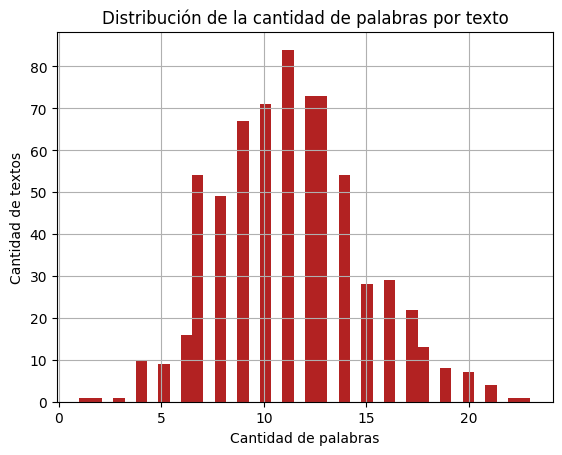

In [123]:
seq_len = [len(text.split()) for text in train_data['Headline']]

pd.Series(seq_len).hist(bins = 40, color='firebrick')

plt.title('Distribución de la cantidad de palabras por texto')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Cantidad de textos')

La mayoría de los textos tienen menos de 300 palabras. Por lo que podemos definir un tamaño máximo de 300 palabras. Esto nos permitirá reducir el tamaño de los textos, y así reducir el tiempo de entrenamiento del modelo.

In [124]:
MAX_LENGTH = 15

# Tokeniza los textos de entrenamiento
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True,
)

# Tokeniza los textos de validación
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True,
)

# Tokeniza los textos de prueba
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True,
)

c:\Users\PC\OneDrive\Escritorio\Universidad\Semestre 10\AyPIT\DetectorFakeNews_AyPIT_2025-2\venv2\Lib\site-packages\transformers\tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [125]:
# Convierte los tokens de entrenamiento tensores de PyTorch
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# Convierte los tokens de validación tensores de PyTorch
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# Convierte los tokens de prueba tensores de PyTorch
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [126]:
# Data Loader para el conjunto de entrenamiento
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32 # El batch es el número de ejemplos que se procesan en una sola iteración del modelo.

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data) # Aleatorio para el entrenamiento
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Data Loader para el conjunto de validación
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data) # Secuencial para la validación
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

En el siguiente paso, congelaremos las capas del modelo BERT, para que no se actualicen durante el entrenamiento. Esto nos permitirá utilizar el modelo preentrenado de BERT como un extractor de características, y así reducir el tiempo de entrenamiento del modelo.

In [127]:
for param in bert.parameters():
    param.requires_grad = False # Congela los parámetros del modelo BERT

### Definición de la arquitectura del modelo


In [128]:
import torch.nn as nn

class BERT_Architecture(nn.Module):
    def __init__(self, bert):
        super(BERT_Architecture, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.1) # Dropout para evitar el sobreajuste
        self.relu = nn.ReLU() # Función de activación ReLU
        self.fc1 = nn.Linear(768, 512) # Capa densa con 768 entradas y 256 salidas
        self.fc2 = nn.Linear(512, 2) # Capa densa con 256 entradas y 2 salidas (Fake y True)
        self.softmax = nn.LogSoftmax(dim=1) # Función de activación softmax

    def forward(self, sent_id, mask):
        # Pasa las entradas a través del modelo BERT
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

        x = self.fc1(cls_hs) # Pasa por la primera capa densa
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x) # Pasa por la segunda capa densa
        x = self.softmax(x) # Aplica la función softmax para obtener probabilidades
        return x
    
model = BERT_Architecture(bert) # Inicializa el modelo

# Definimos los hiperparámetros (optimizador, pesos de las clases y cantidad de épocas)
from torch.optim import AdamW # Optimizador AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5) # Tasa de aprendizaje

# Definición de la función de pérdida
cross_entropy = nn.NLLLoss()

# Cantidad de épocas de entrenamiento
epochs = 2

### Definición de las funciones de Entrenamiento y Evaluación

In [129]:
def train():
    model.train() # Configura el modelo en modo de entrenamiento
    total_loss, total_accuracy = 0, 0 # Inicializa la pérdida y la precisión totales

    for step, batch in enumerate(train_dataloader): # Itera sobre la cantidad de batches
        if step % 50 == 0 and not step == 0: # Avanza cada 50 batches
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        batch = [r for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad() # Limpia los gradientes del modelo
        preds = model(sent_id, mask) # Realiza la predicción
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward() # Calcula los gradientes
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy() # Desacopla los tensores de la GPU

    avg_loss = total_loss / len(train_dataloader) # Calcula la pérdida promedio

    return avg_loss

def evaluate():
    print("\nEvaluando...")
    model.eval() # Configura el modelo en modo de evaluación
    total_loss, total_accuracy = 0, 0 # Inicializa la pérdida y la precisión totales
    
    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        batch = [t for t in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
            preds = preds.detach().cpu().numpy()
    avg_loss = total_loss / len(val_dataloader) # Calcula la pérdida promedio
    return avg_loss

## Entrenamiento del modelo

In [130]:
# Enrenamiento y evaluación del modelo
best_valid_loss = float('inf') # Inicializa la mejor pérdida de validación
train_losses, valid_losses = [], [] # Inicializa las listas de pérdidas de entrenamiento y validación

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train() # Entrena el modelo
    valid_loss = evaluate() # Evalúa el modelo
    if valid_loss < best_valid_loss: # Guarda el mejor modelo
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_weights.pt')
    train_losses.append(train_loss) # Guarda la pérdida de entrenamiento
    valid_losses.append(valid_loss) # Guarda la pérdida de validación

    print(f'\nPerdida de entrenamiento: {train_loss:.3f}')
    print(f'\nPerdida de validación: {valid_loss:.3f}')


 Epoch 1 / 2

Evaluando...

Perdida de entrenamiento: 0.696

Perdida de validación: 0.688

 Epoch 2 / 2

Evaluando...

Perdida de entrenamiento: 0.696

Perdida de validación: 0.688


## Performance del modelo

In [131]:
# Carga el mejor modelo
path = 'best_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [132]:
import numpy as np
from sklearn.metrics import classification_report

with torch.no_grad():
    preds = model(test_seq, test_mask) # Realiza la predicción
    preds = preds.detach().cpu().numpy() # Desacopla los tensores de la GPU

preds = np.argmax(preds, axis=1) # Obtiene las etiquetas predichas
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.75      0.46      0.57        26
           1       0.60      0.84      0.70        25

    accuracy                           0.65        51
   macro avg       0.68      0.65      0.64        51
weighted avg       0.68      0.65      0.63        51



In [ ]:
noticia_fake = [
    "El presidente de la nación ha anunciado que el país se convertirá en el primero en colonizar Marte.",
    "Un estudio revela que el chocolate es la clave para vivir más de 100 años.",
    "La NASA ha encontrado vida en la luna de Júpiter.",
    "Un nuevo medicamento promete curar todas las enfermedades en una semana.",
]

# Tokeniza la noticia
tokens = tokenizer.batch_encode_plus(
    noticia_fake,
    max_length=15,
    pad_to_max_length=True,
    truncation=True,
)

# Convierte los tokens a tensores de PyTorch
tokens_seq = torch.tensor(tokens['input_ids'])
tokens_mask = torch.tensor(tokens['attention_mask'])

# Realiza la predicción
with torch.no_grad():
    preds = model(tokens_seq, tokens_mask) # Realiza la predicción
    preds = preds.detach().cpu().numpy() # Desacopla los tensores de la GPU

preds = np.argmax(preds, axis=1) # Obtiene las etiquetas predichas
for i in preds:
    if i == 0:
        print("La noticia es FALSA")
    else:
        print("La noticia es VERDADERA")

La noticia es VERDADERA
La noticia es FALSA
La noticia es VERDADERA
La noticia es VERDADERA
